In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import time
import os
from datetime import datetime, timedelta


%matplotlib inline

### Reading initial dataset

In [2]:
df_train = pd.read_csv('../input/kuzushiji-recognition/train.csv')
unicode_map = {codepoint: char for codepoint, char in 
               pd.read_csv('../input/kuzushiji-recognition/unicode_translation.csv').values}

### A bit of statistics

In [3]:
def convert_labels_set(labels_str):
    labels = []
    for one_label_str in re.findall(r'U\+\S+\s\S+\s\S+\s\S+\s\S+', labels_str):
        charcode, x, y, w, h = one_label_str.split(' ')
        labels.append([charcode, int(x), int(y), int(w), int(h)])
    return labels

In [4]:
n_labels = 0
chars_counts = {}

for labels_set in df_train.values[:, 1]:
    if type(labels_set) is not str:
        continue

    labels = convert_labels_set(labels_set)
    n_labels += len(labels)
    for label in labels:
        try:
            chars_counts[label[0]] += 1
        except KeyError:
            chars_counts.update({label[0]: 1})

chars_counts_list = [chars_counts[k] for k in chars_counts]
n_classes = len([k for k in chars_counts])

print('Number of labels:                  {}'.format(n_labels))
print('Number of classes:                 {}'.format(n_classes))
print('Min max number of items per class: {} {}'.format(np.min(chars_counts_list), np.max(chars_counts_list)))
print('Median number of items per class:  {}'.format(np.median(chars_counts_list)))
print('Mean number of items per class:    {}'.format(np.mean(chars_counts_list)))

Number of labels:                  683464
Number of classes:                 4212
Min max number of items per class: 1 24685
Median number of items per class:  9.0
Mean number of items per class:    162.26590693257359


### Making dataset

In [5]:
def get_char_images_from_sheet(src_image_path, labels_str, blur_kernel_size=3, img_size=64):
    src_img = cv2.imread(src_image_path, cv2.IMREAD_COLOR)

    char_imgs, labels_codes = [], []
    for label in convert_labels_set(labels_str):
        char_img = np.zeros((img_size, img_size), dtype=np.uint8)
        charcode, x, y, w, h = label

        label_img = src_img[y:y + h, x:x + w, :]
        label_img = cv2.GaussianBlur(label_img, 
                                     (blur_kernel_size, blur_kernel_size), 
                                     cv2.BORDER_DEFAULT)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
        _, label_img = cv2.threshold(label_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        label_img = 255 - label_img
        
        if w > h:
            label_img = cv2.resize(label_img, (img_size, int(img_size * h / w)))
            dy = int((img_size - int(img_size * h / w)) / 2)
            char_img[dy:dy + int(img_size * h / w), :] += label_img
        
        else:
            label_img = cv2.resize(label_img, (int(img_size * w / h), img_size))            
            dx = int((img_size - int(img_size * w / h)) / 2)
            char_img[:, dx:dx + int(img_size * w / h)] += label_img
        
        char_imgs.append(char_img)
        labels_codes.append(charcode)
    return char_imgs, labels_codes

In [6]:
img_size = 64
generator_out_depth = 64

chars_imgs = []
chars_labels = []

for value in df_train.values:
    img_filename, labels_str = value
    try:
        imgs, labels = get_char_images_from_sheet('../input/kuzushiji-recognition/train_images/{}.jpg'.format(img_filename), labels_str, img_size=img_size)
    except TypeError:
#         print('Unable to parse {}'.format(labels_str))
        continue
#     imgs = [(image - 127.5).astype('float32') / 127.5 for image in imgs]
#     imgs = [image.reshape(img_size, img_size, 1) for image in imgs]
    chars_imgs.extend(imgs)
    chars_labels.extend(labels)

In [7]:
chars_imgs = np.array(chars_imgs)
np.min(chars_imgs), np.max(chars_imgs), chars_imgs.shape

(0, 255, (683464, 64, 64))

### DCGAN: The simplest example

In [8]:
from tensorflow.keras import layers
import tensorflow as tf

In [18]:
generator_out_depth = 16
discriminator_in_depth = 16


#### Generator

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((img_size / 4) * (img_size / 4) * generator_out_depth * 4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((int(img_size / 4), int(img_size / 4), generator_out_depth * 4)))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 4) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(generator_out_depth * 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(generator_out_depth, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 2, img_size / 2, generator_out_depth)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_size, img_size, 1)

    return model

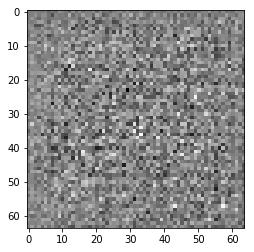

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(discriminator_in_depth, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(discriminator_in_depth * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00213788]], shape=(1, 1), dtype=float32)


## Losses

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimisers

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training loop

In [35]:
checkpoint_dir = '../working/dcgan_chekpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [36]:
EPOCHS = 50
BATCH_SIZE = 4096
checkpoints_step = 10

noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [37]:
def convert_images_to_tf(images):
    out_images = (images - 127.5).astype('float32') / 127.5
    out_images = out_images.reshape(images.shape[0], img_size, img_size, 1)
    return out_images

In [38]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('../working/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for _ in range(int(dataset.shape[0] / BATCH_SIZE)):
        image_batch = dataset[np.random.choice(range(dataset.shape[0]), BATCH_SIZE)]
        converted_images = convert_images_to_tf(image_batch)
        train_step(converted_images)

    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % checkpoints_step == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, epochs, seed)

### Training

In [40]:
train_dataset = chars_imgs

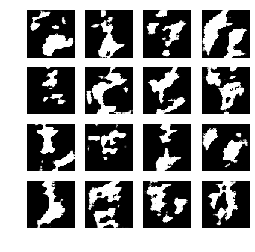

Time for epoch 1 is 144.81681632995605 sec


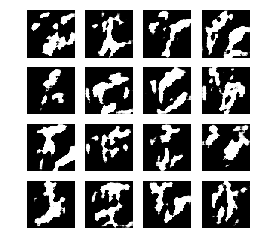

Time for epoch 2 is 140.12937927246094 sec


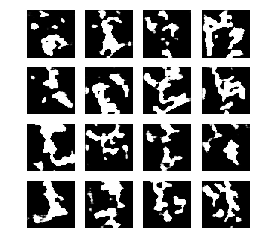

Time for epoch 3 is 140.11543607711792 sec


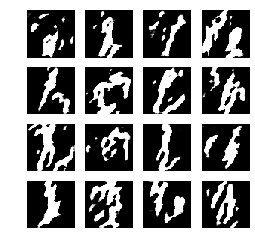

Time for epoch 4 is 139.46142959594727 sec


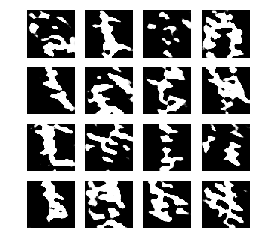

Time for epoch 5 is 138.73362231254578 sec


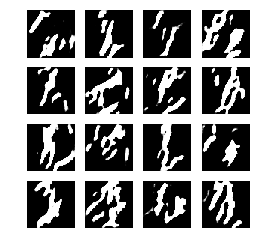

Time for epoch 6 is 141.2205605506897 sec


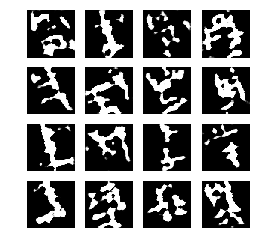

Time for epoch 7 is 138.7959713935852 sec


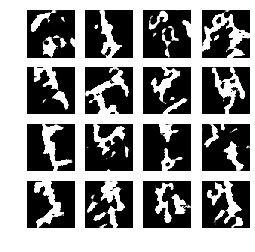

Time for epoch 8 is 139.83341789245605 sec


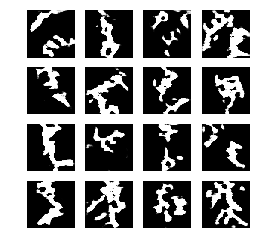

Time for epoch 9 is 141.82202696800232 sec


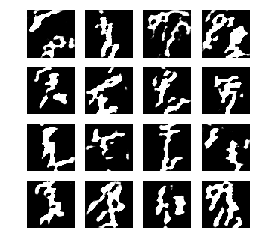

Time for epoch 10 is 138.8009672164917 sec


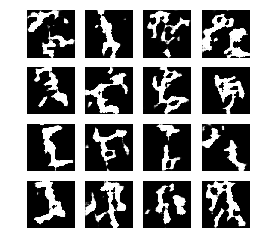

Time for epoch 11 is 139.41745519638062 sec


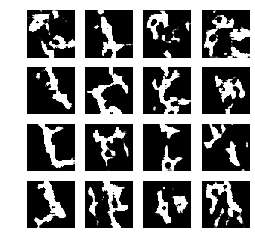

Time for epoch 12 is 139.2651801109314 sec


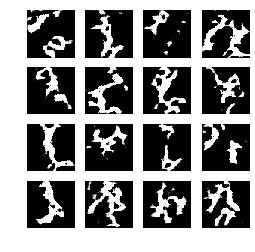

Time for epoch 13 is 141.64425134658813 sec


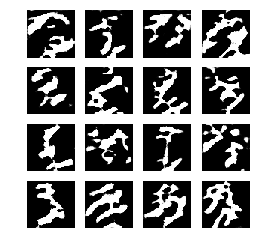

Time for epoch 14 is 138.800359249115 sec


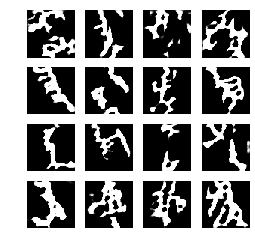

Time for epoch 15 is 138.852778673172 sec


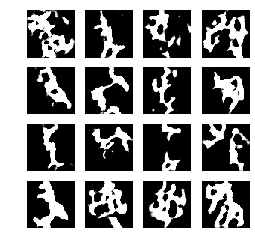

Time for epoch 16 is 138.86760449409485 sec


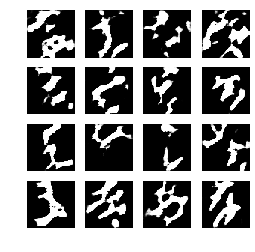

Time for epoch 17 is 140.19104743003845 sec


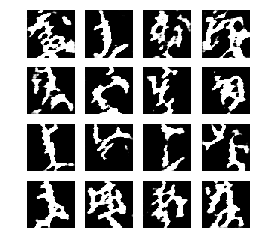

Time for epoch 18 is 139.8183753490448 sec


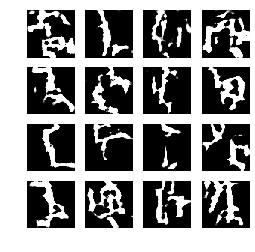

Time for epoch 19 is 138.26677751541138 sec


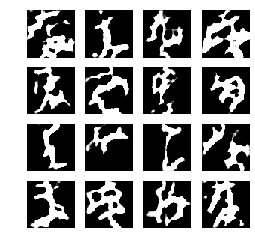

Time for epoch 20 is 139.44741654396057 sec


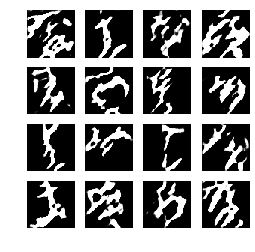

Time for epoch 21 is 141.3613657951355 sec


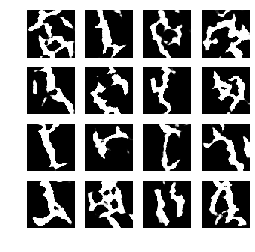

Time for epoch 22 is 140.03270530700684 sec


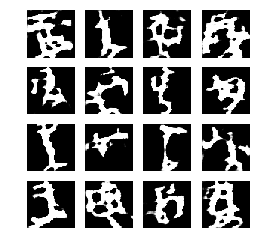

Time for epoch 23 is 140.5491542816162 sec


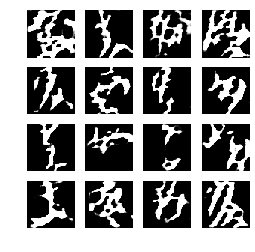

Time for epoch 24 is 140.42894387245178 sec


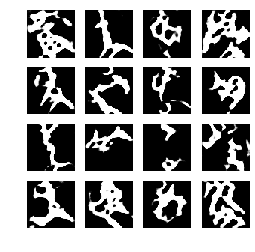

Time for epoch 25 is 138.64415049552917 sec


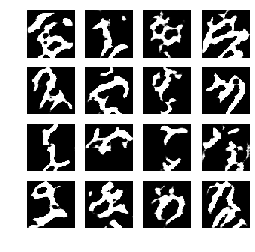

Time for epoch 26 is 140.1214714050293 sec


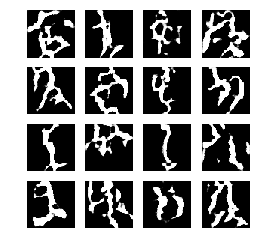

Time for epoch 27 is 140.82097601890564 sec


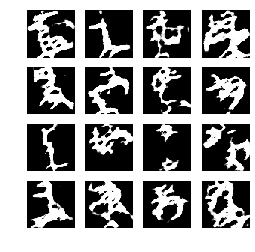

Time for epoch 28 is 140.72365283966064 sec


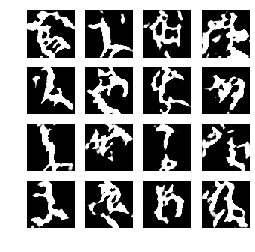

Time for epoch 29 is 139.2800121307373 sec


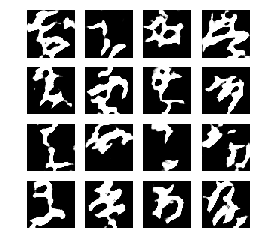

Time for epoch 30 is 139.10492968559265 sec


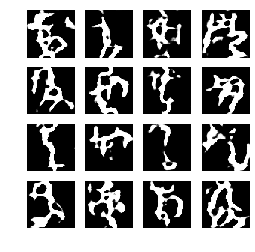

Time for epoch 31 is 139.1111569404602 sec


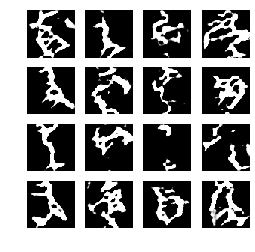

Time for epoch 32 is 139.18898963928223 sec


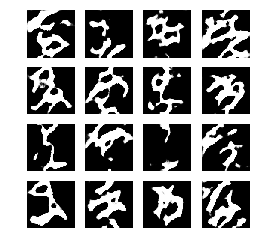

Time for epoch 33 is 139.85318040847778 sec


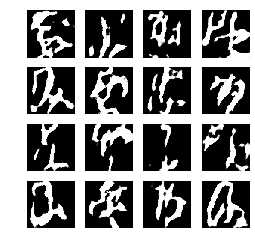

Time for epoch 34 is 139.40905952453613 sec


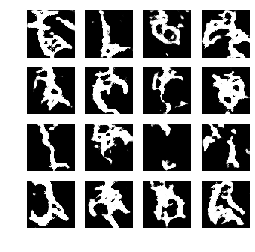

Time for epoch 35 is 139.0973937511444 sec


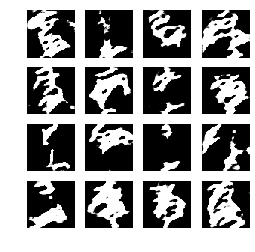

Time for epoch 36 is 139.6318006515503 sec


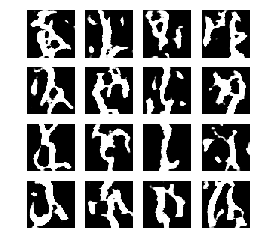

Time for epoch 37 is 140.12674808502197 sec


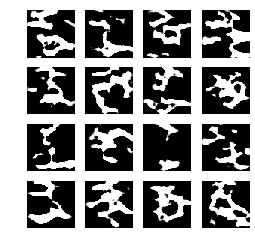

Time for epoch 38 is 140.60423278808594 sec


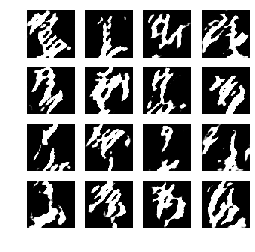

Time for epoch 39 is 139.37769842147827 sec


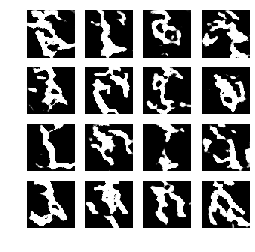

Time for epoch 40 is 139.2252321243286 sec


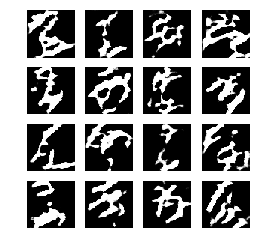

Time for epoch 41 is 140.68345522880554 sec


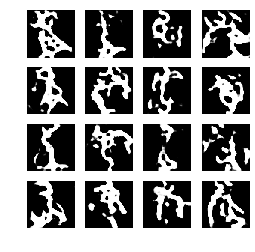

Time for epoch 42 is 139.65277218818665 sec


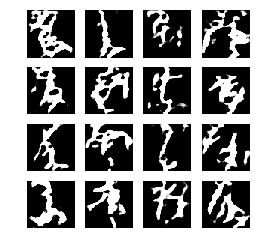

Time for epoch 43 is 140.29168319702148 sec


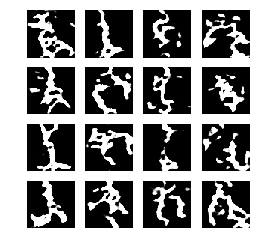

Time for epoch 44 is 139.0239760875702 sec


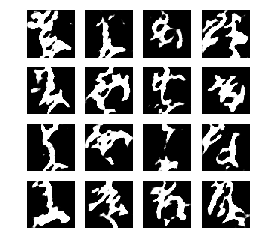

Time for epoch 45 is 139.8125298023224 sec


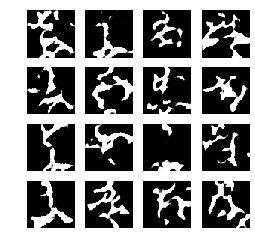

Time for epoch 46 is 137.3953309059143 sec


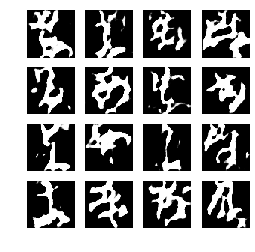

Time for epoch 47 is 139.8322536945343 sec


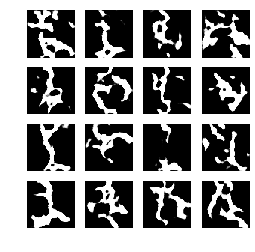

Time for epoch 48 is 141.94131183624268 sec


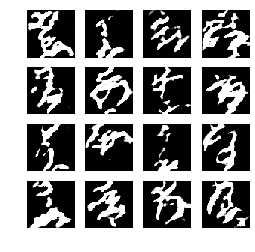

Time for epoch 49 is 139.60276556015015 sec


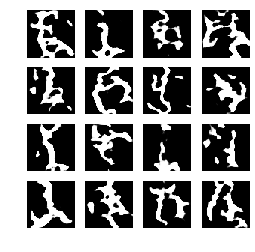

Time for epoch 50 is 139.9724497795105 sec


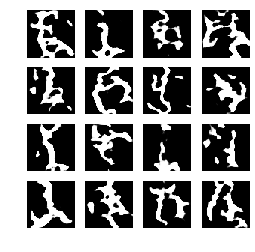

CPU times: user 49min 44s, sys: 1h 6min 6s, total: 1h 55min 51s
Wall time: 1h 56min 33s


In [41]:
%%time
train(train_dataset, EPOCHS)

In [65]:
from subprocess import check_output
# print(check_output(["ls", "-lah", "../working"]).decode("utf8"))
print(check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8"))

checkpoint
ckpt-1.data-00000-of-00002
ckpt-1.data-00001-of-00002
ckpt-1.index
ckpt-2.data-00000-of-00002
ckpt-2.data-00001-of-00002
ckpt-2.index
ckpt-3.data-00000-of-00002
ckpt-3.data-00001-of-00002
ckpt-3.index
ckpt-4.data-00000-of-00002
ckpt-4.data-00001-of-00002
ckpt-4.index
ckpt-5.data-00000-of-00002
ckpt-5.data-00001-of-00002
ckpt-5.index



## An attempt to save data

In [49]:
import zipfile

In [55]:
with zipfile.ZipFile('../working/porgress_at_images.zip', 'w') as imgs_zip:
    for i in range(1, 51):
        imgs_zip.write('../working/image_at_epoch_00{:02d}.png'.format(i))

In [66]:
with zipfile.ZipFile('../working/nns_checkpoints.zip', 'w') as checkpoints_zip:
    for filename in check_output(["ls", "../working/dcgan_chekpoints"]).decode("utf8").split('\n'):
        checkpoints_zip.write('../working/dcgan_chekpoints/{}'.format(filename))

In [68]:
# from IPython.display import FileLink, FileLinks
# FileLinks('.')